<a href="https://colab.research.google.com/github/nkthiebaut/guanaco/blob/fine-tuning/QLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantized Low-Rank Adapters (QLoRA)

Paper: https://arxiv.org/pdf/2305.14314

PEFT library guide: https://huggingface.co/docs/peft/en/developer_guides/lora#lora

Let's start with a review of quantization. A naive quantization scheme from fp32 to int8 would look like this:

$$
\mathbf{X}^{\mathrm{Int8}}=\operatorname{round}\left(\frac{127}{\operatorname{absmax}\left(\mathbf{X}^{\mathrm{FP} 32}\right)} \mathbf{X}^{\mathrm{FP} 32}\right)=\operatorname{round}\left(c^{\mathrm{FP} 32} \cdot \mathbf{X}^{\mathrm{FP} 32}\right)
$$

Let's see the kind of approximations that are made with this quantization.

In [1]:
%pip install -q accelerate bitsandbytes trl peft transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
def quantize(value, bits=4):
    """Implement "naive" integer quantization with rescaling."""
    quantized_value = np.round(value * (2**(bits - 1) - 1))
    return int(quantized_value)

def dequantize(quantized_value, bits=4):
    """Inverse operation"""
    value = quantized_value / (2**(bits - 1) - 1)
    return float(value)

## Exercise: compute quantized values for different inputs and measure the error

Let’s plot a curve with the unquantized values of a cosine.


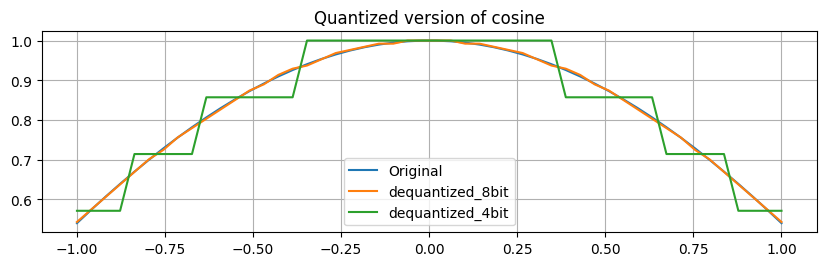

In [6]:
# Source: https://github.com/peremartra/Large-Language-Model-Notebooks-Course
x = np.linspace(-1, 1, 50)
y = [math.cos(val) for val in x]

y_quant_8bit = np.array([quantize(val, bits=8) for val in y])
y_dequant_8bit = np.array([dequantize(val, bits=8) for val in y_quant_8bit])

y_quant_4bit = np.array([quantize(val, bits=4) for val in y])
y_dequant_4bit = np.array([dequantize(val, bits=4) for val in y_quant_4bit])


plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(x, y, label="Original")
plt.plot(x, y_dequant_8bit, label="dequantized_8bit")
plt.plot(x, y_dequant_4bit, label="dequantized_4bit")
plt.legend()
plt.title("Quantized version of cosine")
plt.grid(True)

In [23]:
from huggingface_hub import login
login()

In [11]:

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer
import torch

model_name = "bigscience/bloomz-560m"
target_modules = ["query_key_value"]

# model_name = "meta-llama/Meta-Llama-3-8B"
# target_modules = ["q_proj", "v_proj"]

To load the model, we need a configuration class that specifies how we want the quantization to be performed. We’ll achieve this with the BitesAndBytesConfig from the Transformers library.

In [12]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

We are specifying the use of 4-bit quantization and also enabling double quantization to reduce the precision loss.

For the bnb_4bit_quant_type parameter, I've used the recommended value in the paper [QLoRA: Efficient Finetuning of Quantized LLMs.](https://arxiv.org/abs/2305.14314)

Now, we can go ahead and load the model.

In [13]:
device_map = {"": 0}
foundation_model = AutoModelForCausalLM.from_pretrained(
    model_name, quantization_config=bnb_config, device_map=device_map, use_cache = False
)

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Now we have the quantized version of the model in memory. Yo can try to load the unquantized version to see if it's possible.

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [15]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=False, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id,
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [16]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as a motivational coach.  I am not saying that your life should be perfect, but it is important for the person who has been in this relationship.']


The answer is good enough, the models used is a really well trained Model. But we will try to improve the quality with a sort fine-tuning process.


## Preparing the Dataset.
Let's use a chat dataset with prompts
https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [17]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)

data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

del data
train_sample = train_sample.remove_columns('act')

display(train_sample)

Generating train split:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [18]:
print(train_sample[:1])

{'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[44, 4026, 1152, 427, 1769, 661, 267, 104105, 28434, 17, 473, 2152, 4105, 49123, 530, 1152, 2152, 57502, 1002, 3595, 368, 28434, 3403, 6460, 17, 473, 4026, 1152, 427, 3804, 57502, 1002, 368, 28434, 10014, 14652, 2592, 19826, 4400, 10973, 15, 530, 16915, 4384, 17, 727, 1130, 11602, 184637, 17, 727, 1130, 4105, 49123, 35262, 473, 32247, 1152, 427, 727, 1427, 17, 3262, 707, 3423, 427, 13485, 1152, 7747, 361, 170205, 15, 707, 2152, 727, 1427, 1331, 55385, 5484, 14652, 6291, 999, 117805, 731, 29726, 1119, 96, 17, 2670, 3968, 9361, 632, 269, 4

## Fine-Tuning.
The first step will be to create a LoRA configuration object where we will set the variables that specify the characteristics of the fine-tuning process.

In [19]:
import peft
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=target_modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

In [20]:
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [21]:
import transformers
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True,
    learning_rate= 2e-4,
    num_train_epochs=5
)

In [22]:
tokenizer.pad_token = tokenizer.eos_token

trainer = SFTTrainer(
    model=foundation_model,
    args=training_args,
    train_dataset=train_sample,
    peft_config = lora_config,
    dataset_text_field="prompt",
    tokenizer=tokenizer,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=35, training_loss=3.067557416643415, metrics={'train_runtime': 29.8004, 'train_samples_per_second': 8.389, 'train_steps_per_second': 1.174, 'total_flos': 50717413933056.0, 'train_loss': 3.067557416643415, 'epoch': 5.0})

## Inference with the pretrained model

In [ ]:
from peft import AutoPeftModelForCausalLM, PeftConfig

device_map = {"": 0}
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")
peft_model_path = os.path.join(output_directory, f"lora_model")


In [ ]:
bnb_config2 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
loaded_model = AutoPeftModelForCausalLM.from_pretrained(
    peft_model_path,
    is_trainable=False,
    quantization_config=bnb_config2,
    device_map='cuda'
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Inference the fine-tuned model.

In [ ]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt").to('cuda')
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['I want you to act as a motivational coach.  I will provide some information about an individual or group of people who need motivation, and your role is help them find the inspiration they require in order achieve their goals successfully! You can use techniques such as positive reinforcement, visualization exercises etc., depending on what']


## Exercise: fine-tune your model on the Orca dataset